In [1]:
import os
import pickle
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import beta, linregress, norm
import matplotlib.dates as mdates


# Constants

In [2]:
HUGGINGFACE_FOLDER = "data/elo-results"
OUTPUT_FOLDER = "output"

EXTENSION_FACTOR = 2.0
CI_Z = 1.96
SKEW_MEAN = 1.0
SKEW_STD = 0.1

In [3]:
sns.set_context("talk", font_scale=1)


# Data Processing

## Data Cleaning Helpers

In [4]:
def load_elo_results(input_folder, output_folder):
    elo_results_list = []

    for f in os.listdir(input_folder):
        if f.endswith(".pkl"):
            with open(f"{input_folder}/{f}", "rb") as f:
                data = dict(pickle.load(f))
                keys = data.keys()
                date = datetime.strptime(f.name[-12:-4], "%Y%m%d")
                
                if 'text' in keys:
                    df = (
                        data['text']['no_refusal']['leaderboard_table_df']
                        .reset_index()
                        .rename(columns={
                            'rating': 'elo_score',
                            'index': 'model'
                        })
                    )
                    
                elif 'leaderiboard_table_df' in keys:
                    df = (
                        data['leaderboard_table_df']
                        .reset_index()
                        .rename(columns={
                            'rating': 'elo_score',
                            'index': 'model'
                        })
                    )
                    
                elif 'leaderboard_table' in keys:
                    table_str = data['leaderboard_table']
    
                    rows = table_str.split('\n')[2:]

                    parsed_rows = [{
                        'elo_score': int(row[2]),
                        'model': re.search(r'\[([^\]]+)\]', row[1]).group(1)
                        } for row in map(lambda x: x.strip('| \n').split('|'), rows) if len(row) == 4]
                    
                    df = pd.DataFrame(parsed_rows)
                    
                df['date'] = date
                elo_results_list.append(df)

    elo_results_df = pd.concat(elo_results_list)
    elo_results_df.to_csv(f"{OUTPUT_FOLDER}/elo_results.csv", index=False)
    return elo_results_df


## Load/Process Data

In [5]:
if os.path.exists(f"{OUTPUT_FOLDER}/elo_results.csv"):
    elo_results_df = pd.read_csv(f"{OUTPUT_FOLDER}/elo_results.csv")
else:
    elo_results_df = load_elo_results(HUGGINGFACE_FOLDER, OUTPUT_FOLDER)

elo_results_df['date'] = pd.to_datetime(elo_results_df['date'])
elo_results_df.sort_values(by=['date', 'elo_score'], ascending=False, inplace=True)
rank_one_elo_results_df = elo_results_df.groupby('date').head(1)

In [6]:
print('ELO results: \n', elo_results_df.head(), '\n')
print('Rank one ELO results: \n', rank_one_elo_results_df.head())


ELO results: 
                            model    elo_score   variance  rating_q975  \
3621    gemini-2.5-pro-exp-03-25  1441.984655   8.448213  1447.436508   
3716               o3-2025-04-16  1417.269623  17.981757  1424.455532   
3569  chatgpt-4o-latest-20250326  1414.868669   8.728007  1419.777985   
3666        grok-3-preview-02-24  1406.946660   7.193417  1412.209858   
3601                early-grok-3  1405.613126   7.206888  1410.282194   

      rating_q025  num_battles  final_ranking       date  
3621  1436.683680      12388.0            2.0 2025-05-05  
3716  1409.114184       5653.0            7.0 2025-05-05  
3569  1409.646487      10143.0            8.0 2025-05-05  
3666  1401.520045      14648.0            8.0 2025-05-05  
3601  1400.610684      13609.0            8.0 2025-05-05   

Rank one ELO results: 
                           model    elo_score   variance  rating_q975  \
3621   gemini-2.5-pro-exp-03-25  1441.984655   8.448213  1447.436508   
4197   gemini-2.5-pro-

# Modeling

## Estimating Long Term Trend

In [7]:
class LongTermPrediction:
    def __init__(self, data):
        self.elo_results = data
        self.top_elo_results = self.elo_results.groupby('date').head(1)
        
    def estimate_daily_model_releases(self):
        self.model_release_date_estimates = (
            self.elo_results.groupby('model')['date']
            .min()
            .reset_index()
        )

        self.daily_release_counts = (
            self.model_release_date_estimates.groupby('date')
            .size()
            .reset_index()
            .rename(columns={0: 'count'})
        )
        

    def visualize_complete_daily_model_releases(self):
        self.crazy_start = pd.to_datetime("2024-04-01")
        self.crazy_end = pd.to_datetime("2024-06-30")
        
        sns.set_context(context='talk', font_scale=1)
        fig, ax1 = plt.subplots(figsize=(12, 6))

        sns.lineplot(
            data=self.daily_release_counts,
            x='date',
            y='count',
            marker='o',
            linewidth=2,
            ax=ax1,
            label="Release Count"
        )
        ax1.set_ylabel("Release Count", color='tab:blue')
        ax1.set_ylim(top=110)
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.legend(loc='lower right', fontsize='small')

        start = pd.to_datetime("2024-04-03")
        end = pd.to_datetime("2024-04-18")
        ax1.axvspan(start, end, color="#4d4d4d", alpha=0.8, label="Suspicious Dates")

        ax1.annotate(
            'Unusually high release count',
            xy=(start + (end - start) / 4, 60),            
            xytext=(pd.to_datetime("2023-5-10"), 87),  
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12,
            ha='left'
        )

        ax2 = ax1.twinx()

        sns.lineplot(
            data=self.top_elo_results,
            x='date',
            y='elo_score',
            marker='o',
            linewidth=2,
            ax=ax2,
            color='tab:red',
            label="ELO Score"
        )
        ax2.set_ylabel("ELO Score", color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        self.crazy_start = pd.to_datetime("2024-04-01")
        self.crazy_end = pd.to_datetime("2024-06-30")
        ax2.axvspan(self.crazy_start, self.crazy_end, color="#4d4d4d", alpha=0.25)
        
        ax1.annotate(
            'Crazy World Window',
            xy=(pd.to_datetime("2024-05-10"), 60),            
            xytext=(self.crazy_start + pd.Timedelta(days=90), 87), 
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12,
            ha='left'
        )

        ax1.set_title("Daily Model Release Count and Top ELO Score")
        ax1.set_xlabel("Date")
        ax1.grid(True)
        fig.tight_layout()
        plt.show()
        
    def remove_crazy_world(self):
        self.top_elo_results_normal = self.top_elo_results[
            (self.top_elo_results['date'] < self.crazy_start) |
            (self.top_elo_results['date'] > self.crazy_end)
        ]
        
        self.top_elo_results_crazy = self.top_elo_results[
            (self.top_elo_results['date'] >= self.crazy_start) &
            (self.top_elo_results['date'] <= self.crazy_end)
        ]
        

    def get_outliers(self):
        return self.outlier_dates
    
    def fit_linear_normal(self, verbose = False):
        regression_data = self.top_elo_results_normal.copy()
        outlier_data = self.top_elo_results_crazy.copy()
        
        slope, intercept, r_value, p_value, std_err = linregress(x = regression_data['date'].map(pd.Timestamp.toordinal),
                                                         y = regression_data['elo_score'])
        
        regression_data['x'] = regression_data['date'].map(pd.Timestamp.toordinal)
        regression_data['elo_predicted'] = slope * regression_data['x'] + intercept
        regression_data['residual'] = regression_data['elo_score'] - regression_data['elo_predicted']

        self.r_squared = r_value**2
        
        outlier_data['x'] = outlier_data['date'].map(pd.Timestamp.toordinal)
        outlier_data['elo_predicted'] = slope * outlier_data['x'] + intercept

        outlier_data['residual'] = outlier_data['elo_score'] - outlier_data['elo_predicted']
        

        self.average_residual = outlier_data['residual'].mean()
        
        if verbose == True:
            print(f"R^2 on outlier dates: {self.r_squared:.2f}")
            

            plt.figure(figsize=(10, 6))
            sns.scatterplot(
                x=regression_data['elo_score'],
                y=regression_data['residual'],
                alpha=0.8
            )
            plt.axhline(0, color='gray', linestyle='--')
            plt.xlabel("Predicted ELO")
            plt.ylabel("Residual")
            plt.title("Residuals vs Predicted ELO")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(10, 6))
            sns.lineplot(
                data=regression_data,
                x='date',
                y='elo_score',
                label='Actual ELO Score',
                marker='o',
                linestyle='-',
                alpha=0.7
            )
            sns.lineplot(
                data=regression_data,
                x='date',
                y='elo_predicted',
                label='Regression Line',
                linestyle='--',
                color='red'
            )
            
            plt.title("ELO Score Over Time with Linear Regression Line")
            plt.xlabel("Date")
            plt.ylabel("ELO Score")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
    def fit_linear_normal_truncated(self, verbose = False): 
        regression_data = self.top_elo_results_normal.copy()
        outlier_data = self.top_elo_results_crazy.copy()
        
        regression_data = regression_data[regression_data['date'] >= self.crazy_end]
        
        slope, intercept, r_value, p_value, std_err = linregress(x = regression_data['date'].map(pd.Timestamp.toordinal),
                                                         y = regression_data['elo_score'])
        
        regression_data['x'] = regression_data['date'].map(pd.Timestamp.toordinal)
        regression_data['elo_predicted'] = slope * regression_data['x'] + intercept
        regression_data['residual'] = regression_data['elo_score'] - regression_data['elo_predicted']

        self.r_squared = r_value**2
        
        outlier_data['x'] = outlier_data['date'].map(pd.Timestamp.toordinal)
        outlier_data['elo_predicted'] = slope * outlier_data['x'] + intercept

        outlier_data['residual'] = outlier_data['elo_score'] - outlier_data['elo_predicted']
        

        self.average_residual = outlier_data['residual'].mean()
        self.slope = slope
        self.intercept = intercept
        
        if verbose == True:
            print(f"R^2 on outlier dates: {self.r_squared:.2f}")


            plt.figure(figsize=(10, 6))
            sns.scatterplot(
                x=regression_data['elo_predicted'],
                y=regression_data['residual'],
                alpha=0.8
            )
            
            plt.axhline(0, color='gray', linestyle='--')
            plt.xlabel("Predicted ELO")
            plt.ylabel("Residual")
            plt.title("Residuals vs Predicted ELO (Truncated)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(10, 6))
            sns.lineplot(
                data=regression_data,
                x='date',
                y='elo_score',
                label='Actual ELO Score',
                marker='o',
                linestyle='-',
                alpha=0.7
            )
            sns.lineplot(
                data=regression_data,
                x='date',
                y='elo_predicted',
                label='Regression Line',
                linestyle='--',
                color='red'
            )
            
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            
            plt.title("ELO Score Over Time with Linear Regression (Truncated)")
            plt.xlabel("Date")
            plt.ylabel("ELO Score")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            full_data = self.top_elo_results.copy()
            full_data['x'] = full_data['date'].map(pd.Timestamp.toordinal)
            full_data['elo_predicted'] = slope * full_data['x'] + intercept

            plt.figure(figsize=(12, 6))
            sns.lineplot(
                data=full_data,
                x='date',
                y='elo_score',
                label='ELO Score',
                marker='o'
            )
            sns.lineplot(
                data=full_data,
                x='date',
                y='elo_predicted',
                label='Regression (Fit on Normal)',
                linestyle='--',
                color='red'
            )

            plt.axvspan(self.crazy_start, self.crazy_end, color="#4d4d4d", alpha=0.25, label='Crazy World Window')

            midpoint = self.crazy_start + (self.crazy_end - self.crazy_start) / 2
            plt.annotate(
                f"Avg Residual in Crazy Window:\n{self.average_residual:.2f}",
                xy=(midpoint, full_data['elo_score'].max() - 20),
                xytext=(midpoint + pd.Timedelta(days=60), full_data['elo_score'].max() - 20),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=12,
                ha='left'
            )

            plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

            plt.title("ELO Score Over Time (Full Data) with Regression Line (Truncated)")
            plt.xlabel("Date")
            plt.ylabel("ELO Score")
            plt.legend(loc='upper left', fontsize='small')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

## Preliminary Analysis

In [8]:
long_term = LongTermPrediction(elo_results_df)


In [9]:
long_term.estimate_daily_model_releases()


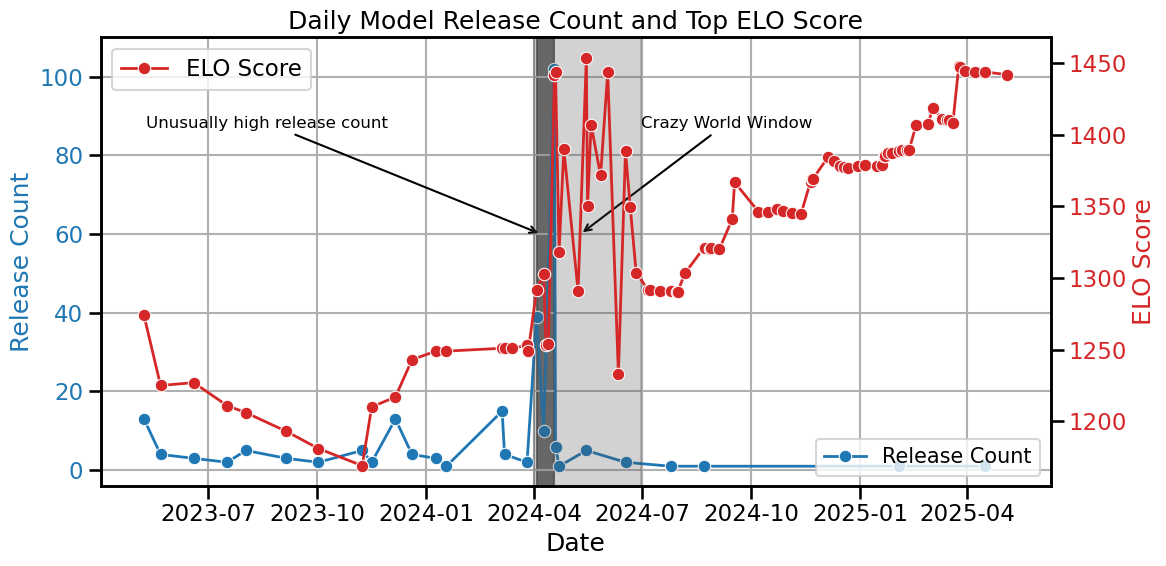

In [10]:
long_term.visualize_complete_daily_model_releases()        


In [11]:
long_term.remove_crazy_world()  

## Run Linear Regression and Estimate

R^2 on outlier dates: 0.89


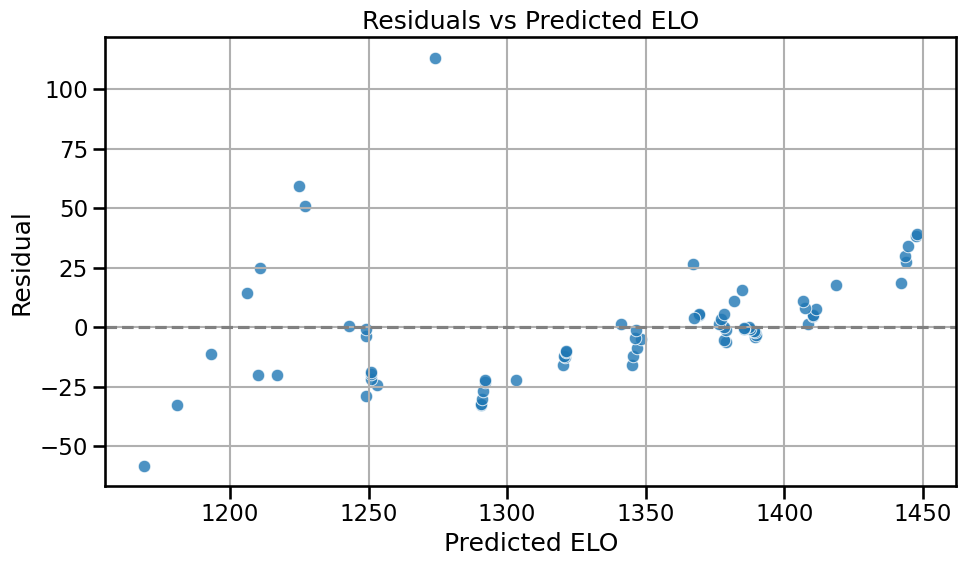

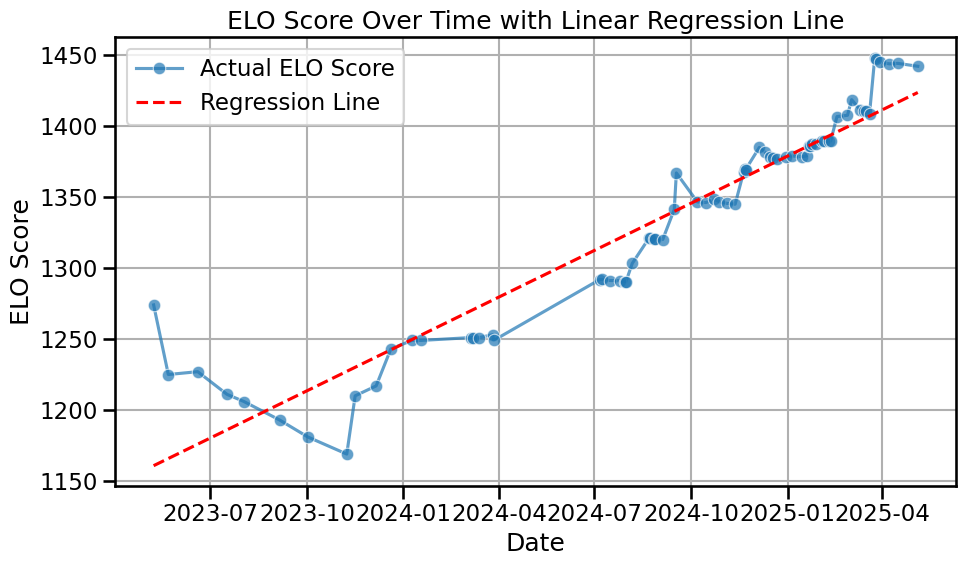

In [12]:
long_term.fit_linear_normal(verbose = True)


R^2 on outlier dates: 0.94


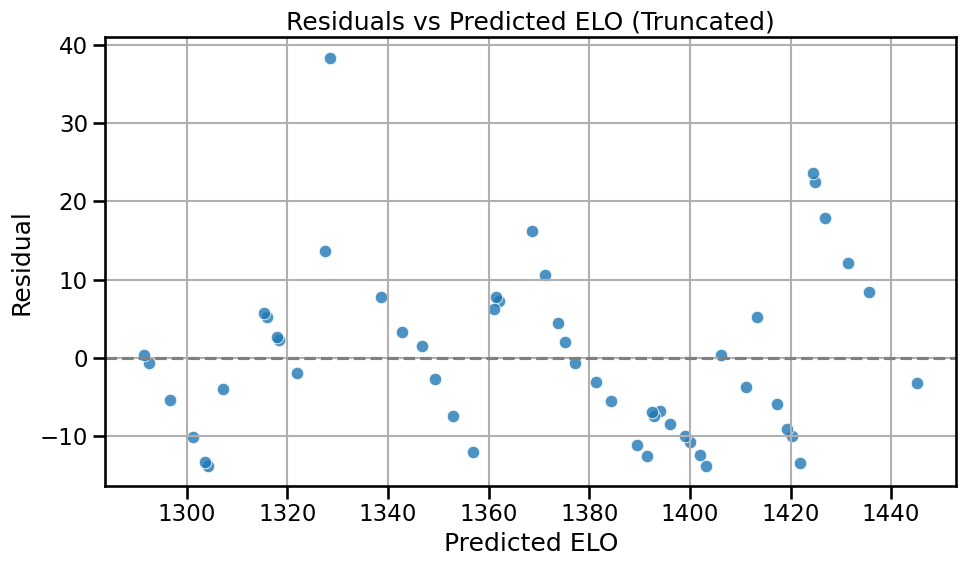

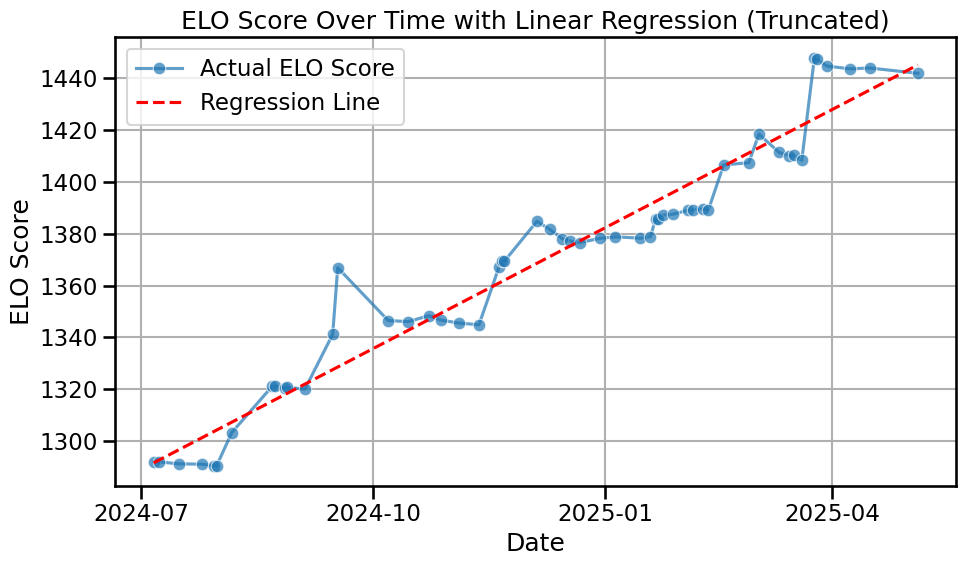

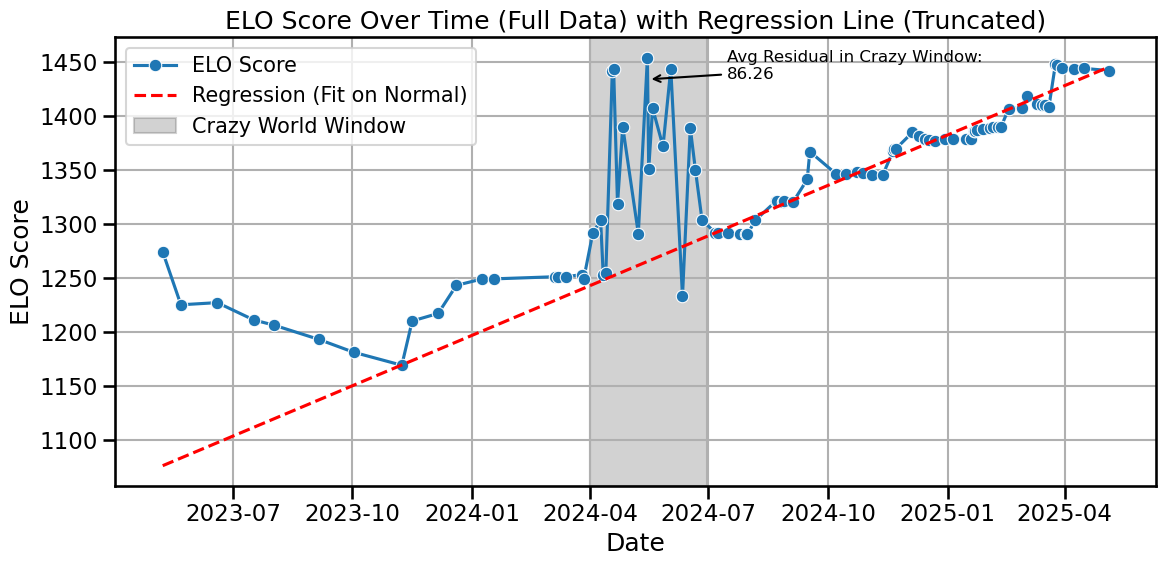

In [13]:
long_term.fit_linear_normal_truncated(verbose = True)

## Estimating Short Term Variations.

In [14]:
class SkewedBeta:
    def __init__(self, a, b, loc, scale, skew_mean=1.0, skew_std=0.1):
        self.base = beta(a, b, loc=loc, scale=scale)
        self.skew_mean = skew_mean
        self.skew_std = skew_std

    def rvs(self, size=1000):
        base_samples = self.base.rvs(size=size)
        skew_factors = norm.rvs(loc=self.skew_mean, scale=self.skew_std, size=size)
        return base_samples * skew_factors

    def pdf(self, x):
        return self.base.pdf(x)

    def cdf(self, x):
        return self.base.cdf(x)

    def ppf(self, q):
        return self.base.ppf(q)

    def mean(self):
        return self.base.mean()

    def std(self):
        return self.base.std()

In [15]:
class Prediction:
    def __init__(self, rank_one_elo_results_df, target_date):
        self.rank_one_elo_results_df = rank_one_elo_results_df
        self.target_date = target_date
        
    def fit_beta_from_ci(self, mean, lower_bound, upper_bound):
        min_val = mean - (mean - lower_bound) * EXTENSION_FACTOR
        max_val = mean + (upper_bound - mean) * EXTENSION_FACTOR
        scale = max_val - min_val
        loc = min_val

        mean_norm = (mean - loc) / scale
        lower_norm = (lower_bound - loc) / scale
        upper_norm = (upper_bound - loc) / scale

        def objective(params):
            a, b = params
            if a <= 0 or b <= 0:
                return np.inf
            pred_mean = a / (a + b)
            pred_std = np.sqrt((a * b) / ((a + b)**2 * (a + b + 1)))
            ci_width = 2 * CI_Z * pred_std
            ci_lower = pred_mean - ci_width / 2
            ci_upper = pred_mean + ci_width / 2
            return (mean_norm - pred_mean)**2 + (lower_norm - ci_lower)**2 + (upper_norm - ci_upper)**2

        res = minimize(objective, [2, 5], bounds=[(1e-3, None), (1e-3, None)])
        a, b = res.x

        return SkewedBeta(a, b, loc, scale, skew_mean=SKEW_MEAN, skew_std=SKEW_STD)

    def fit_beta_dists(self, rank_one_elo_results_df):
        beta_dists = []
        for _, row in rank_one_elo_results_df.iterrows():
            dist = self.fit_beta_from_ci(
                mean=row['elo_score'], 
                lower_bound=float(row['rating_q025']), 
                upper_bound=float(row['rating_q975'])
            )
            beta_dists.append(dist)
            
        return beta_dists
        
    def generate_weights(self, rank_one_elo_results_df, num_days):
        considered_days_df = rank_one_elo_results_df.sort_values('date', ascending=False).head(num_days).reset_index(drop=True)

        days_since_start = (considered_days_df['date'] - considered_days_df['date'].min()).dt.days + 1
        weights = np.exp(days_since_start / num_days)
        weights /= weights.sum()
        
        return weights

    def create_mixture_dist(self, beta_dists, weights, visualize=True):
        x_min = min([dist.ppf(0.001) for dist in beta_dists])
        x_max = max([dist.ppf(0.999) for dist in beta_dists])
        x = np.linspace(x_min, x_max, 1000)
        mixture_pdf = np.zeros_like(x)
        
        self.x = x
        self.mixture_pdf = mixture_pdf
        
        pdfs = []
        
        for (w, dist) in zip(weights, beta_dists):
            pdf = dist.pdf(x)
            mixture_pdf += w * pdf
            pdfs.append(pdf)
            
        if visualize:
            individual_plots = []
            for i, (w, pdf) in enumerate(zip(weights, pdfs)):
                for j in range(len(x)):
                    individual_plots.append({
                        "elo_score": x[j],
                        "density": pdf[j],
                        "day": f"Day {i+1} (w={w:.5f})"
                    })
                    
            invidiual_plots_df = pd.DataFrame(individual_plots)
                    
            plt.figure(figsize=(10, 6))
            sns.set_context("talk", font_scale=0.5)
            palette = sns.color_palette("viridis", len(weights))

            sns.lineplot(
                x=x,
                y=mixture_pdf,
                label="Mixture Distribution",
                color="black",
                linewidth=1.8
            )
            
            sns.lineplot(
                data=invidiual_plots_df,
                x="elo_score",
                y="density",
                hue="day",
                palette=palette,
                linewidth=1
            )

            plt.title("Weighted Mixture of Distributions", fontsize=18)
            plt.xlabel("ELO Score", fontsize=14)
            plt.ylabel("Density", fontsize=14)
            plt.legend(title="Distributions", fontsize=10, title_fontsize=11)
            plt.tight_layout()
            plt.show()
        
        self.mixture_df = pd.DataFrame({
            'elo_score': x,
            'density': mixture_pdf
        })
        
        return self.mixture_df
    
    def shift_mixture_dist(self, rate_of_increase):
        x = self.x
        mixture_pdf = self.mixture_df['density']
        p0_func = interp1d(x, mixture_pdf, kind='linear', bounds_error=False, fill_value=0)

        delta = rate_of_increase * (pd.to_datetime(self.target_date) - rank_one_elo_results_df['date'].max()).days

        x_new = np.linspace(x.min(), x.max() + delta, len(x))  
        final_pdf = p0_func(x_new - delta) 

        plt.figure(figsize=(12, 6))
        sns.set_context("talk")

        sns.lineplot(x=x, y=mixture_pdf, label="Original Dist", color="black", linewidth=1.5)
        sns.lineplot(x=x_new, y=final_pdf, label=f"Shifted Dist → (Δ = {delta:.1f})", color="darkgreen", linewidth=1.5)

        plt.title("Distribution Shifted Along ELO Score Axis", fontsize=18)
        plt.xlabel("ELO Score", fontsize=14)
        plt.ylabel("Density", fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        self.final_df = pd.DataFrame({
            'elo_score': x_new,
            'density': final_pdf
        })
        
    def simulation_crazy_world(self, crazy_world_shift, es, verbose = True, iter = 1000):
        def p0():
            return np.random.choice(self.final_df['elo_score'], 
                                    p = self.final_df['density'] / self.final_df['density'].sum())

        def p1():
            return mean_elo + crazy_world_shift

        def mixture(p0, p1, e=0.001):
            if np.random.rand() < e:
                return p1()
            else:
                return p0()
            
        mean_elo = (self.final_df['elo_score'] * self.final_df['density']).sum() / self.final_df['density'].sum() 
            
        simulations = {}

        for e in es:
            simulations[e] = []
            for _ in range(iter):
                simulations[e].append(mixture(p0, p1, e))

        lower_bounds, upper_bounds, means = [], [], []

        for (e, sim) in simulations.items():
            sim = np.array(sim)
            
            lower_bound = np.quantile(sim, 0.10)
            upper_bound = np.quantile(sim, 0.90)
            mean = sim.mean()
            if verbose:
                print("\n")
                print(f"80% CI lower bound (e = {e}): {lower_bound:.2f}")
                print(f"80% CI upper bound (e = {e}): {upper_bound:.2f}")
                print(f"Mean (e = {e}): {mean:.2f}")
            
            lower_bounds.append(lower_bound)
            upper_bounds.append(upper_bound)
            means.append(mean)
            
        return np.mean(lower_bounds), np.mean(upper_bounds), np.mean(means)
    

Chosen weights: 
 0    0.765305
1    0.114466
2    0.051433
3    0.020911
4    0.014017
5    0.012683
6    0.007693
7    0.005699
8    0.004666
9    0.003128
Name: date, dtype: float64


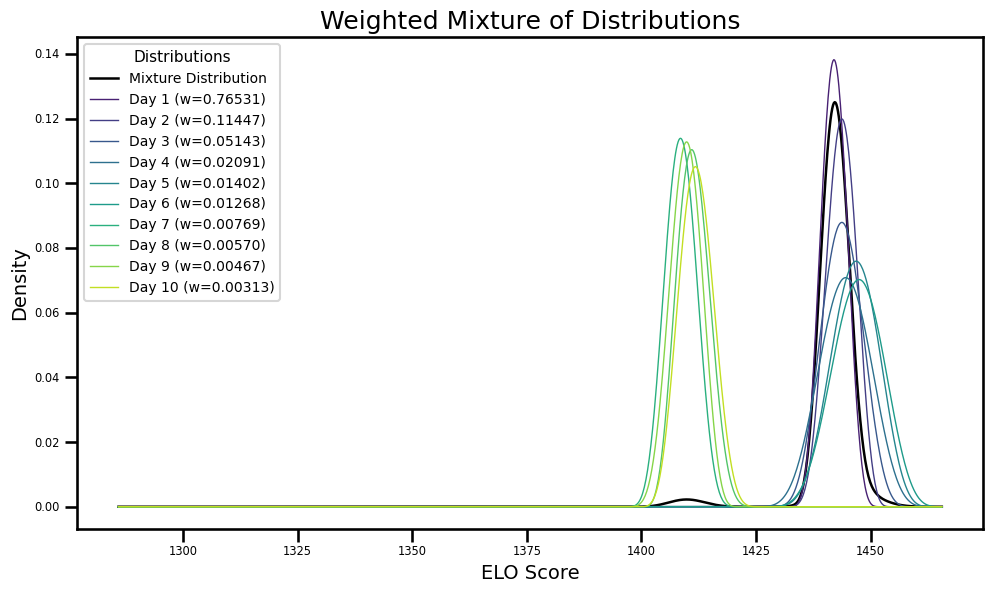

Mixture distribution: 
        elo_score       density
995  1464.829949  1.299102e-07
996  1465.009778  8.049397e-08
997  1465.189606  4.741671e-08
998  1465.369435  2.626164e-08
999  1465.549264  1.346831e-08


In [16]:
prediction = Prediction(rank_one_elo_results_df, '2025-12-31')

beta_dists = prediction.fit_beta_dists(rank_one_elo_results_df)
weights = prediction.generate_weights(rank_one_elo_results_df, num_days = 10)

print(f'Chosen weights: \n', weights)

mixture_df = prediction.create_mixture_dist(beta_dists, weights)
print(f'Mixture distribution: \n', mixture_df.tail())

# Final Prediction

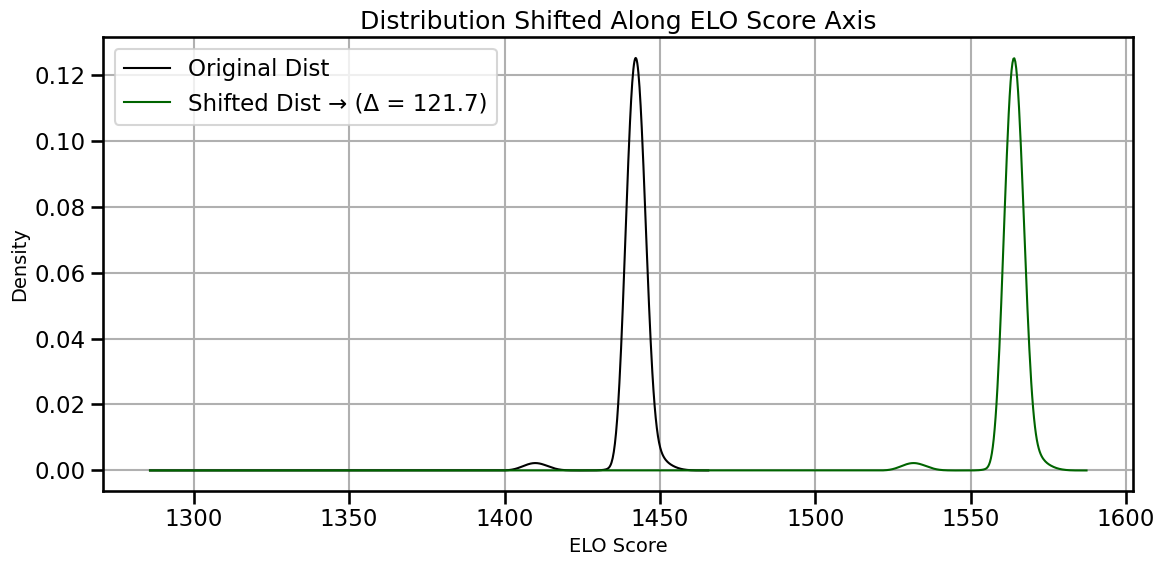

Final Prediction: 
80% CI lower bound: 1559.95
80% CI upper bound: 1568.10
Mean: 1563.69


In [17]:
prediction.shift_mixture_dist(rate_of_increase = long_term.slope)
lower_bound, upper_bound, mean = prediction.simulation_crazy_world(crazy_world_shift = long_term.average_residual,
                                                                   es = (0.001, 0.0001, 0.00001, 0.000001, 0.0000001), verbose = False)

print("Final Prediction: ")
print(f"80% CI lower bound: {lower_bound:.2f}")
print(f"80% CI upper bound: {upper_bound:.2f}")
print(f"Mean: {mean:.2f}")

In [18]:
print(long_term.slope)

0.5072324632781688
